In [1]:
import sys
sys.path.append("/Users/Tanay/Desktop/CS269I/StableCoinSimulator/PyLOB/")

import math
from random import randint
from numpy.random import normal
from collections import defaultdict, OrderedDict, deque
from PyLOB import OrderBook
import matplotlib.pyplot as plt
import numpy as np
import time
import json
# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
def biased_coin(prob):
    return int(np.random.random() < prob)

In [3]:
def clamp_bas_price(price):
    # 1 BAS = price ETH
    return np.clip(price, 0, 10.0)

def clamp_bas_qty(qty): 
    # Max order size of $100,000
    return np.clip(qty, 0, 1e5)

def months_to_seconds(mths):
    return mths * 30 * 24 * 60 * 60

In [4]:
class BasisBond: 
    def __init__(self, tid, timestamp, amount, expiry):
        self.tid = tid
        self.timestamp = int(timestamp)
        self.expirytime = self.timestamp + expiry
        self.amount = amount

In [5]:
class Protocol:
    def __init__(self, totalSupply):
        self.totalSupply = totalSupply
        self.market = None
        
    def update(self):
        pass
        
class BasisProtocol(Protocol):
    
    def __init__(self, totalSupply, market):
        super().__init__(totalSupply)
        self.market = market
        self.bond_expiry = months_to_seconds(60) # 5 year expiry
        self.bondsForAuction = 0
        self.bondQueue = deque()
        
        self.delay = 20000 # In Steps
        self.lastAuction = 0 # Last aucion
        self.currentStep = 0
        
    def issueBonds(self, tid, amount):
        self.bondQueue.append(BasisBond(tid, time.time(), amount, self.bond_expiry))
        self.bondsForAuction -= amount
#         self.market.demandRatio *= (1 + (amount / self.totalSupply))
#         self.market.demandRatio = min(self.market.demandRatio, 1.0)
        # Basis are burnt outside of this code 
        
    def update(self):
        price = self.market.getCurrentUSDValue()
        self.currentStep += 1
        
        LOWER = 0.99
        UPPER = 1.01
        
        # Value of Supply = Market Cap
        # Market Cap is constant, PRICE * QTY = PRICE' * QTY'
        # QTY' = (PRICE / PRICE') * QTY
        #        (0.9 / 1.0) * 1M 
        # delQTY = deviation (0.1) * supply (1M)
        
        # ISSUE bonds
        if price < LOWER:
            if self.currentStep < self.lastAuction + self.delay:
                return
            
            newSupply = price * self.market.avgVolume
            bondsToCreate = self.market.avgVolume - newSupply 
            self.bondsForAuction += bondsToCreate
            self.lastAuction = self.currentStep
            
        elif price > UPPER:
            newSupply = price * self.market.avgVolume
            basisToCreate = newSupply - self.market.avgVolume
            
#             self.market.demandRatio *= (1 - basisToCreate / self.totalSupply)
#             self.market.demandRatio = max(self.market.demandRatio, 0.1)
            
            while len(self.bondQueue) and basisToCreate:
                head = self.bondQueue.popleft()
                if head.amount > basisToCreate:
                    self.market.traderPool[head.tid].bas += basisToCreate
                    head.amount -= basisToCreate
                    basisToCreate = 0
                    self.bondQueue.appendleft(head)
                else:
                    self.market.traderPool[head.tid].bas += head.amount
                    basisToCreate -= head.amount
                    
            if basisToCreate > 0:
                # Distribute to shareholders
                pass
            

In [6]:
class Trader: 
    def __init__(self, tid, protocol, market):
        self.tid = tid
        self.protocol = protocol
        self.market = market
        self.portfolioRatio = 0.5
        self.eth = 10
        self.bas = 1000
        
    def getIdealValue(self):
        return self.eth * 100 + self.bas

    def marketStep(self):
        return None
    
'''
    IdealTrader buys/sells according to market demand. 
    Sets prices to be around the ideal exchange rate ~ 0.01.
'''
class IdealTrader(Trader):
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.bas = int(1e5) # $100,000 in BASIS 
        self.portfolioRatio = 0.05
        
    def marketStep(self):
        BASE_PRICE = self.market.usd_eth # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread

        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(self.market.demandRatio)]
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 8e-5)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)
        
        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = int(normal(qty_mu, qty_sigma) * self.bas)
        qty = clamp_bas_qty(qty)

        if qty <= 0:
            return None
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order
    
class RandomTrader(Trader): 
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.portfolioRatio = 0.05
        self.bas = int(1e4)
        
    def marketStep(self):
        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = normal(qty_mu, qty_sigma) * self.bas
        qty = clamp_bas_qty(qty)
        
        if qty <= 0:
            return None
        
        # Randomly select bid / ask based on market demand
        side = ['ask', 'bid'][biased_coin(self.market.demandRatio)]
        
        # If we aren't buying bonds, then try to trade
        BASE_PRICE = self.market.getIdealETHValue() # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread
        
        # If there is high confidence, then buy bonds in the auction.
        if side == 'ask' and biased_coin(self.market.demandRatio) and self.protocol.bondsForAuction:
            # Buy the bonds for a price 
            price = randint(90, 99) * 0.01 # Gets the price the person is willing to pay for the bonds
            qty = min(qty, self.protocol.bondsForAuction)
            qty = min(qty, self.bas / price)
            self.protocol.issueBonds(self.tid, qty)
            burntBasis = price * qty
            self.bas -= burntBasis
            self.protocol.totalSupply -= burntBasis
            return None
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 0.0001)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order

    
class InvestorTrader(Trader): 
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.portfolioRatio = 0.001
        self.bas = int(1e7)
        self.eth = 1000
    
class TrendMaker(Trader):
    pass

class BasicTrader(Trader): 
    pass

trader_dict = {'IdealTrader': IdealTrader, 'RandomTrader': RandomTrader, 'TrendMaker': TrendMaker, 
               'BasicTrader': BasicTrader, 'InvestorTrader': InvestorTrader}


# Implement TrendMaker, BasicTrader, ShareTokens, ShareHolderTrader


In [7]:
def createTraderPool(protocol, market, demographics):
    traderPool = {}
    uniqTID = 1
    for trader_type, number in demographics.items():
        trader_class = trader_dict[trader_type]
        for i in range(number):
            trader = trader_class(uniqTID, protocol, market)
            traderPool[uniqTID] = trader
            uniqTID += 1
    return traderPool

In [8]:
class Market:
    def __init__(self):
        self.demandRatio = 0.5 # in [0, 1]
        
        # ETH Trades
        self.usd_eth = 0.01
        self.bas_eth = 0.01
        
        self.orderbook = OrderBook(tick_size=0.0001)
        self.traderPool = {}
        
        self.prices = defaultdict(list)
        self.protocol = None
        self.marketSpeed = 0.9
        
        self.askVolume = 0
        self.bidVolume = 0
        self.avgVolume = 0
        self.movingAvgVel = 0.01
        
    def setTraderPool(self, traderPool):
        self.traderPool = traderPool
        
        if self.protocol:
            basis = 0
            for trader in traderPool.values():
                basis += trader.bas
            self.protocol.totalSupply = basis
        
        self.orderbook.setTraderPool(traderPool)
        
    def getIdealETHValue(self):
        return self.marketSpeed * self.usd_eth + (1 - self.marketSpeed) * self.getCurrentETHValue()
        
    def getCurrentUSDValue(self, func_type='avg_edge_bidask'):
        return self.getCurrentETHValue(func_type) / self.usd_eth
        
    ''' Returns the value of BASIS in USD '''
    def getCurrentETHValue(self, func_type='wavg_edge_bidask'):
        def avg_bidask():
            return (self.orderbook.getBestBid() + self.orderbook.getBestAsk()) / 2
        
        def wavg_bidask():
            bid_price, ask_price = self.orderbook.getBestBid(), self.orderbook.getBestAsk()
            bid_vol = self.orderbook.getVolumeAtPrice('bid', bid_price)
            ask_vol = self.orderbook.getVolumeAtPrice('ask', ask_price)
            total_vol = bid_vol + ask_vol
            return (bid_price * ask_vol + ask_price * bid_vol) / total_vol
        
        if self.orderbook.getBestBid() is None:
            if self.orderbook.getBestAsk() is not None: 
                return self.orderbook.getBestAsk() # ask, not bid
            else:
                return self.bas_eth # not ask, not bid
        elif self.orderbook.getBestAsk() is None:
            return self.orderbook.getBestBid() # not ask, bid
        
        func_list = {'avg_edge_bidask': avg_bidask, 'wavg_edge_bidask': wavg_bidask}
        
        return func_list[func_type]()
        
    def setProtocol(self, protocol):
        self.protocol = protocol
        
    def processOrder(self, quote):
        
        if quote['side'] == 'bid':
            self.bidVolume += quote['qty']
        else:
            self.askVolume += quote['qty']
        
        trades, idNum = self.orderbook.processOrder(quote, False, False)
        
        volumeTraded = sum([trade['qty'] for trade in trades])
        self.bidVolume -= volumeTraded
        self.askVolume -= volumeTraded
        
        totalVolume = self.bidVolume + self.askVolume
        self.avgVolume = totalVolume * self.movingAvgVel + self.avgVolume * (1 - self.movingAvgVel)
        
        for func in ['avg_edge_bidask', 'wavg_edge_bidask']:
            self.prices[func].append(self.getCurrentUSDValue(func))
            
        if self.protocol is not None:
            self.protocol.update()
            
        return trades, idNum

In [19]:
trader_demographics = OrderedDict()
trader_demographics['IdealTrader'] = 5
trader_demographics['RandomTrader'] = 1000
trader_demographics['InvestorTrader'] = 5

In [20]:
market = Market()
basis = BasisProtocol(int(1e7), market)
market.protocol = basis
traderPool = createTraderPool(basis, market, trader_demographics)
market.setTraderPool(traderPool)

cur_time = 0
market.usd_eth = 1 / get_eth_price(0)
market.bas_eth = 1 / get_eth_price(0)
usd_eth_price_track = []

In [21]:
eth_prices = json.load(open('etherium.json'))

def get_eth_price(t):
    T = 15000
    idx = t // T
    lin = (t % T) / (1. * T)
    if idx >= len(eth_prices) - 1:
        return eth_prices[-1]
    return eth_prices[idx] * (1.0 - lin) + eth_prices[idx + 1] * lin

In [22]:
initialOrders = []
NUM_ORDERS = 2000
NUM_TRADERS = trader_demographics['IdealTrader'] # We initially set it up with randomTraders

for _ in range(NUM_ORDERS):
    market.usd_eth = 1 / get_eth_price(cur_time) 
    usd_eth_price_track.append(market.usd_eth)
    
    tid = randint(1, NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order:
        initialOrders.append(order)
    cur_time += 1
    
for i, order in enumerate(initialOrders):
    trades, idNum = market.processOrder(order)

In [23]:
def bin_data(data, bin_size):
    valid_length = (data.shape[0] // bin_size) * bin_size
    data = data[:valid_length]
    N = data.shape[0]
    binned = np.zeros(N // bin_size)
    for k in range(0, N, bin_size):
        binned[k // bin_size] = data[k : k + bin_size].mean()
    return binned

def plot_prices(market, price_func, bin_size=50, warmup=100): 
    data = np.array(market.prices[price_func])[warmup:]
    binned = bin_data(data, bin_size)
    
    binned = binned
    ideal = np.ones(binned.shape)
    plt.plot(ideal, 'r')
    plt.plot(binned, 'b')
    plt.ylim(0.5, 1.5)

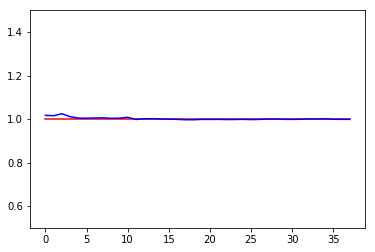

In [24]:
plot_prices(market, 'wavg_edge_bidask')

In [ ]:
NUM_ORDERS_LIVE = 150000
# We initially set it up with randomTraders
NUM_TRADERS = trader_demographics['RandomTrader'] #+ trader_demographics['InvestorTrader']

offset = trader_demographics['IdealTrader']
for i in range(NUM_ORDERS_LIVE):
    market.usd_eth = 1 / get_eth_price(cur_time) 
    usd_eth_price_track.append(market.usd_eth)
    tid = randint(offset + 1, offset + NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order: 
        trades, idNum = market.processOrder(order)    
    cur_time += 1
plot_prices(market, 'wavg_edge_bidask')

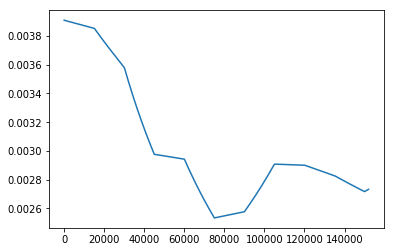

In [17]:
plt.plot(usd_eth_price_track)

(array([  1.00400000e+03,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.00000000e+00]),
 array([  -201075.61 ,    829031.951,   1859139.512,   2889247.073,
          3919354.634,   4949462.195,   5979569.756,   7009677.317,
          8039784.878,   9069892.439,  10100000.   ]),
 <a list of 10 Patch objects>)

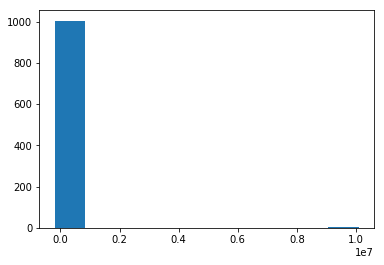

In [18]:
final_values = [trader.getIdealValue() for trader in traderPool.values()]
plt.hist(final_values, bins=10)